In [ ]:
#!pip install optuna

In [ ]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from skorch import NeuralNetBinaryClassifier

import seaborn as sns
import warnings
#import optuna
#from optuna.trial import TrialState
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.0
DAMPENING = 0
NESTEROV = False
L2 = 0.0
EPOCHS = 60

N_TRAIN_EXAMPLES = BATCH_SIZE * 30
N_VALID_EXAMPLES = BATCH_SIZE * 10

In [ ]:
#function to compute the accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
def modelSelection(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 6
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 5)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.BatchNorm1d(out_features))
        p = trial.suggest_float("dropout_l{}".format(i), 0.5, 0.8)
        layers.append(nn.Dropout(p))
        
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    #layers.append(nn.LogSoftmax(dim=1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input = 6, hidden_unit1 = 100):
        super(BinaryClassification, self).__init__()
        self.layer_in = nn.Linear(n_input, hidden_unit1)
        #self.layer_1 = nn.Linear(hidden_unit1, hidden_unit2) 
        self.layer_out = nn.Linear(hidden_unit1, 1) 
        self.sigmoid =  nn.Sigmoid()
        #self.batchnorm1 = nn.BatchNorm1d(hidden_unit1)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_unit2)

    def forward(self, inputs, **kwargs):
        x = self.layer_in(inputs)
        #x = self.batchnorm1(x)
        x = self.sigmoid(x)
   
       # x = self.layer_1(x)
        #x = self.batchnorm2(x)
        #x = self.relu(x)

        #x = self.layer_2(x)
        #x = self.batchnorm1(x)
        #x = self.relu(x)
        #x = self.dropout_2(x)

        #x = self.layer_3(x)
        #x = self.batchnorm1(x)
        #x = self.relu(x)
        #x = self.dropout_3(x)

        #x = self.sigmoid(self.layer_out(x))
        x = self.layer_out(x)
        
        return x

In [ ]:
class TuningHP(object):
    def __init__(self, tl, vl):
        self.train_loader = tl
        self.valid_loader = vl

    def __call__(self, trial):
        loss_f = nn.BCELoss(reduction='mean')
        # Generate the model.
        model = modelSelection(trial).to(device)

        # Generate the optimizers.
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

        # Training of the model.
        for epoch in range(EPOCHS):
            model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # Limiting training data for faster epochs.
                #if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
                 #   break

                data, target = data.view(data.size(0), -1).to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = loss_f(output, target)
                loss.backward()
                optimizer.step()
        
            # Validation of the model.
            model.eval()
            correct = 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(self.valid_loader):
                    # Limiting validation data.
                    #if batch_idx * BATCH_SIZE >= N_VALID_EXAMPLES:
                     #   break
                    data, target = data.view(data.size(0), -1).to(device), target.to(device)
                    output = model(data)
                    # Get the index of the max log-probability.
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

            accuracy = correct / min(len(self.valid_loader), N_VALID_EXAMPLES)

            trial.report(accuracy, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return accuracy#function to define the train phase

#def tuningHP(trial, train_loader, valid_loader):  

In [ ]:
#function to define the train phase
def TrainPhase(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
            
        
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f} | Acc: {epoch_acc/len(data_train):.3f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses, aggregated_accuracy

In [ ]:
#function to define the evaluate phase
def Evaluate(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch)
            acc = binary_acc(y_test_pred, y_batch)
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    aggregated_losses.append(epoch_loss/len(data_test))
    aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')

    #aggregated_losses.append(loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'VALIDATION - Epoch {i+0:03}: | Loss: {loss.item():.5f} | Acc: {acc:.3f}')
    
    return ytest_pred, aggregated_losses, aggregated_accuracy
    

In [ ]:
#function to define the evaluate phase
def Evaluate_Test(model, aggregated_losses, aggregated_accuracy, data_test, loss_f):

    y_pred_list = []
    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch)
            acc = binary_acc(y_test_pred, y_batch)
      
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    #ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    print(f'TEST - Loss: {loss.item():.5f} | Acc: {acc:.3f}')
    
    return y_pred_list, aggregated_losses, aggregated_accuracy

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [ ]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
427,1,3,3,2,3,2,2
428,1,3,3,2,3,3,1
429,1,3,3,2,3,3,2
430,1,3,3,2,3,4,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

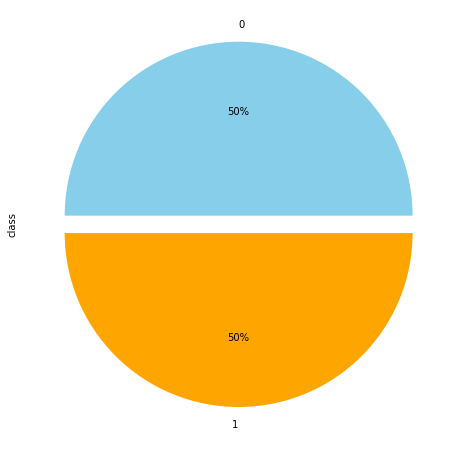

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

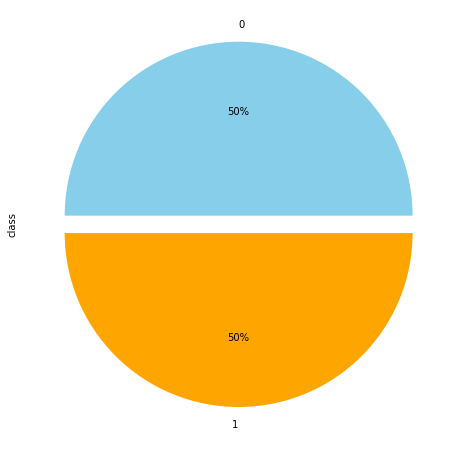

In [ ]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

In [ ]:
#prepare validation set
#X_train, X_validation, y_train, y_validation = train_test_split(df_monk1_train, target_train, stratify=target_train, test_size=0.30)

In [ ]:
#print("Length train data: ", X_train.shape[0])
#print("Length validation data: ", X_validation.shape[0])

In [ ]:
#create tensor for train and test data 
#X_train = X_train.values #returns a ndarray
#X_test = X_test.values
#X_validation = X_validation.values

x_tensor =  torch.from_numpy(X_train_M1).float()
y_tensor =  torch.from_numpy(y_train_M1).float()
#xval_tensor =  torch.from_numpy(X_validation).float()
#yval_tensor =  torch.from_numpy(y_validation.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test_M1).float()
ytest_tensor =  torch.from_numpy(y_test_M1).float()

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

## Training and evaluate
In this section, we train the network and control the results.

study = optuna.create_study(direction="minimize") study.optimize(TuningHP(train_loader, val_loader), n_trials=1000, timeout=1000)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ") print(" Number of finished trials: ", len(study.trials)) print(" Number of pruned trials: ", len(pruned_trials)) print(" Number of complete trials: ", len(complete_trials))
print("Best trial:") trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ") for key, value in trial.params.items(): print(" {}: {}".format(key, value))

losses_train, losses_test, accuracy = tuningHP(trial, model, train_loader, val_loader, EPOCHS, loss_function)
print("ACCURACY: ", accuracy)

### Model selection with skorch and sklearn
In this part, use skorch and sklearn to do a gridsearchcv to find the best model.

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__hidden_unit1=80,
    max_epochs=90,
    batch_size = 64,
    lr = 0.01,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__nesterov=False,
    optimizer__weight_decay=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

In [ ]:
net.fit(X_trainFit, y_trainFit, verbose=0)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6898  0.0132
      2        0.6895  0.0042
      3        0.6877  0.0043
      4        0.6871  0.0030
      5        0.6860  0.0040
      6        0.6850  0.0063
      7        0.6846  0.0057
      8        0.6817  0.0076
      9        0.6802  0.0128
     10        0.6787  0.0049
     11        0.6771  0.0049
     12        0.6755  0.0054
     13        0.6740  0.0057
     14        0.6741  0.0036
     15        0.6709  0.0025
     16        0.6693  0.0053
     17        0.6678  0.0047
     18        0.6662  0.0074
     19        0.6649  0.0078
     20        0.6631  0.0090
     21        0.6616  0.0066
     22        0.6605  0.0048
     23        0.6587  0.0056
     24        0.6574  0.0077
     25        0.6566  0.0080
     26        0.6545  0.0079
     27        0.6531  0.0075
     28        0.6519  0.0048
     29        0.6505  0.0047
     30        0.6490  0.0277
     31        0.6478  0.0083
     32   

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=BinaryClassification(
    (layer_in): Linear(in_features=6, out_features=80, bias=True)
    (layer_out): Linear(in_features=80, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  ),
)

In [ ]:
net.score(X_testFit, y_testFit)

0.6527777777777778

In [ ]:
net.predict(X_testFit)

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    max_epochs=10,
    #batch_size = 1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'max_epochs': [10, 20, 30, 40, 50, 60, 70,  80, 90, 100],
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.8, 0.9, 0.95, 0.85],
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1],
    'optimizer__nesterov': [False, True],
    'module__hidden_unit1': [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'batch_size': [32, 64, 124, 128],
}
gs = RandomizedSearchCV(net, params, n_jobs=-1, refit=True, cv=None, n_iter=50, scoring='accuracy', verbose=2)

X_trainFit = X_train_M1.astype(np.single)
#y_trainFit = y_train.values.ravel()
y_trainFit = y_train_M1.astype(np.single)

X_testFit = X_test_M1.astype(np.single)
#y_valFit = y_validation.values.ravel()
y_testFit = y_test_M1.astype(np.single)

gs.fit(X_trainFit, y_trainFit)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

grid_predictions = gs.predict(X_testFit) 
# print classification report 
print(classification_report(y_testFit, grid_predictions)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best score: 0.684, best params: {'optimizer__weight_decay': 0.01, 'optimizer__nesterov': False, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__hidden_unit1': 80, 'max_epochs': 90, 'lr': 0.01, 'batch_size': 64}
              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65       216
         1.0       0.65      0.67      0.66       216

    accuracy                           0.65       432
   macro avg       0.65      0.65      0.65       432
weighted avg       0.65      0.65      0.65       432



In [ ]:
best_model = gs.best_estimator_
best_model.fit(X_trainFit, y_trainFit)
#y_pred = best_model.predict(X_trainFit)
best_model.score(X_testFit, y_testFit)

0.7060185185185185

In [ ]:
df_results = pd.DataFrame(data=gs.cv_results_) #trasform into a pandas dataframe
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer,param_module__hidden_unit1,param_max_epochs,...,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.176318,0.030548,0.001274,0.000297,0.1,True,0.9,<class 'torch.optim.sgd.SGD'>,50,25,...,64,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.48,0.52,0.52,0.52,0.500000,0.508000,0.016000,33
1,0.505948,0.090804,0.001287,0.000225,0.01,False,0.8,<class 'torch.optim.sgd.SGD'>,5,75,...,64,"{'optimizer__weight_decay': 0.01, 'optimizer__...",0.52,0.52,0.52,0.52,0.500000,0.516000,0.008000,30
2,0.328228,0.065732,0.001285,0.000261,0.001,True,0.95,<class 'torch.optim.sgd.SGD'>,2,60,...,128,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.64,0.68,0.80,0.80,0.500000,0.684000,0.112000,3
3,0.069000,0.027654,0.001133,0.000280,0.001,False,0.9,<class 'torch.optim.sgd.SGD'>,100,10,...,64,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.48,0.48,0.56,0.64,0.500000,0.532000,0.061449,24
4,0.656135,0.120495,0.001473,0.000468,0.1,True,0.8,<class 'torch.optim.sgd.SGD'>,3,60,...,32,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.48,0.52,0.52,0.48,0.500000,0.500000,0.017889,37
5,0.072947,0.020350,0.001453,0.000036,0.1,True,0.95,<class 'torch.optim.sgd.SGD'>,5,10,...,128,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.52,0.48,0.48,0.52,0.541667,0.508333,0.024449,32
6,0.512482,0.077915,0.001195,0.000242,0.01,True,0.9,<class 'torch.optim.sgd.SGD'>,50,100,...,128,"{'optimizer__weight_decay': 0.01, 'optimizer__...",0.56,0.52,0.48,0.48,0.500000,0.508000,0.029933,33
7,0.324774,0.051913,0.001182,0.000250,0.1,False,0.95,<class 'torch.optim.sgd.SGD'>,5,60,...,128,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.60,0.48,0.64,0.48,0.500000,0.540000,0.066933,21
8,0.967753,0.160711,0.010695,0.018924,0.01,False,0.9,<class 'torch.optim.sgd.SGD'>,4,100,...,32,"{'optimizer__weight_decay': 0.01, 'optimizer__...",0.64,0.64,0.72,0.76,0.500000,0.652000,0.089084,8
9,0.311195,0.071263,0.001332,0.000341,0.1,False,0.9,<class 'torch.optim.sgd.SGD'>,4,60,...,124,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.52,0.48,0.48,0.52,0.500000,0.500000,0.017889,37


## Testing model

In [ ]:
#define the model
model = BinaryClassification(X_train_M1.shape[1], 100)
model.to(device)
print(model)

NameError: name 'X_train' is not defined

In [ ]:
#define the loss function 
loss_function = nn.BCELoss(reduction='mean')
#loss_function = nn.MSELoss(reduction='mean')
#define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

After that defined the model, we start the training and evaluating process with prefixed number of epochs. Each epoch, we save the results on lists for plotting the train and evaluate trends.  

#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []
accuracy = 0

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
losses_train, losses_test, accuracy = tuningHP(trial, model, train_loader, val_loader, EPOCHS, loss_function)
print("ACCURACY: ", accuracy)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  # Early stopping
  last_loss = 1
  patience = 2
  trigger_times = 0

  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, val_loader, loss_function)

  # Early stopping
  if losses_test[epoch - 1] > last_loss:
      trigger_times += 1

      if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break
  else:
      trigger_times = 0
  
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.73460 | Acc: 53.000
VALIDATION - Epoch 001: | Loss: 0.69355 | Acc: 50.000
##############################
TRAIN - Epoch 002: | Loss: 0.68334 | Acc: 52.500
VALIDATION - Epoch 002: | Loss: 0.68122 | Acc: 53.000
##############################
TRAIN - Epoch 003: | Loss: 0.67967 | Acc: 61.500
VALIDATION - Epoch 003: | Loss: 0.64935 | Acc: 71.000
##############################
TRAIN - Epoch 004: | Loss: 0.59971 | Acc: 70.000
VALIDATION - Epoch 004: | Loss: 0.60349 | Acc: 66.000
##############################
TRAIN - Epoch 005: | Loss: 0.63354 | Acc: 64.500
VALIDATION - Epoch 005: | Loss: 0.60724 | Acc: 61.000
##############################
TRAIN - Epoch 006: | Loss: 0.52248 | Acc: 78.000
VALIDATION - Epoch 006: | Loss: 0.59101 | Acc: 66.000
##############################
TRAIN - Epoch 007: | Loss: 0.57519 | Acc: 69.500
VALIDATION - Epoch 007: | Loss: 0.56260 | Acc: 71.000
##############################
TRAIN - Epoch 008: | Loss: 0.53832 | Acc: 75.000
VALIDATION - 

In [ ]:
#control the accuracy between true and predict values on test data
#y_true_test = y_test.values.ravel()
#print(classification_report(y_true_test, y_pred_test))

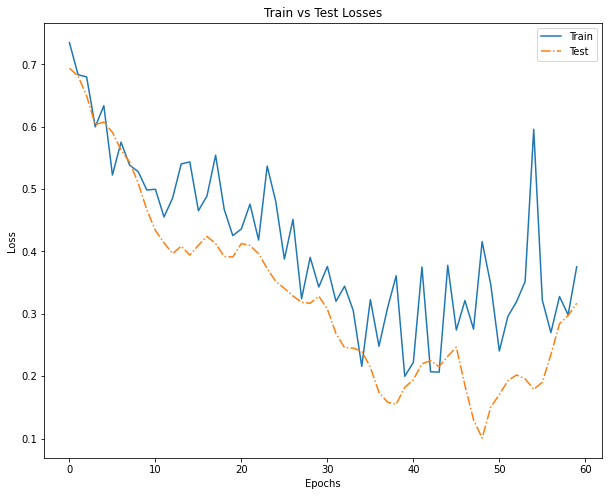

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

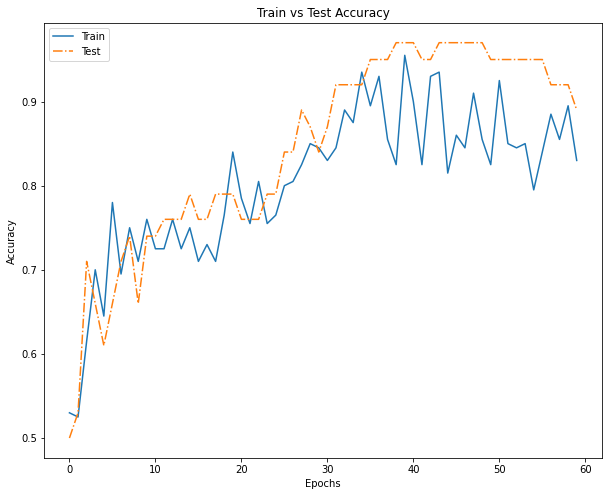

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
y_pred_test, losses_test, accuracies_test = Evaluate_Test(model, losses_test, accuracies_test, test_loader, loss_function)
#control the accuracy between true and predict values on test data

y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

TEST - Loss: 0.18134 | Acc: 100.000
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       216
           1       0.94      0.87      0.90       216

    accuracy                           0.91       432
   macro avg       0.91      0.91      0.91       432
weighted avg       0.91      0.91      0.91       432



### One hot encoding

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train)
X_train = enc_train.transform(X_train).toarray()
print(X_train.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test)
X_test = enc_test.transform(X_test).toarray()
print(X_test.shape)

(86, 17)
(432, 17)


### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

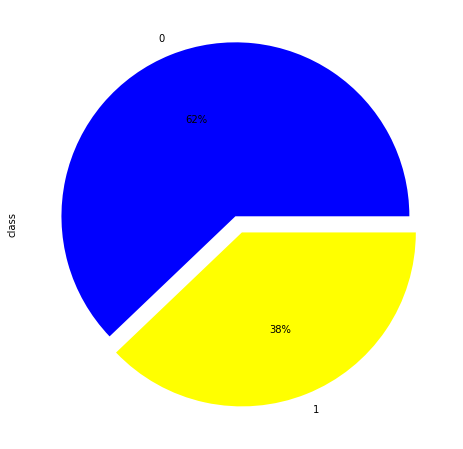

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

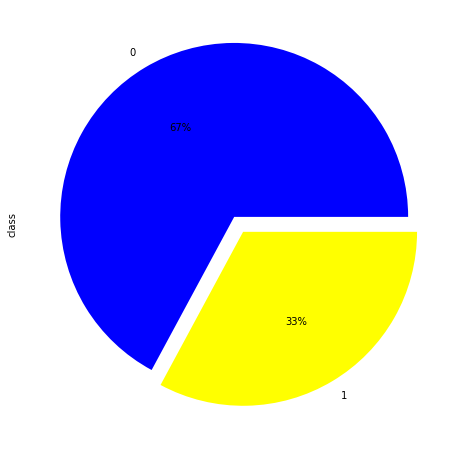

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
target_train = df_monk2_train.pop('class')
target_test = df_monk2_test.pop('class')
X_train = df_monk2_train
y_train = target_train
X_test = df_monk2_test
y_test = target_test

In [ ]:
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
model = BinaryClassification(X_train.shape[1], 100)

In [ ]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")

TRAIN - Epoch 001: | Loss: 0.79590 | Acc: 39.667
VALIDATION - Epoch 001: | Loss: 0.76760 | Acc: 33.000
##############################
TRAIN - Epoch 002: | Loss: 0.76880 | Acc: 37.333
VALIDATION - Epoch 002: | Loss: 0.76498 | Acc: 33.000
##############################
TRAIN - Epoch 003: | Loss: 0.74635 | Acc: 40.000
VALIDATION - Epoch 003: | Loss: 0.76359 | Acc: 33.000
##############################
TRAIN - Epoch 004: | Loss: 0.77428 | Acc: 38.333
VALIDATION - Epoch 004: | Loss: 0.76221 | Acc: 33.000
##############################
TRAIN - Epoch 005: | Loss: 0.75678 | Acc: 40.667
VALIDATION - Epoch 005: | Loss: 0.76075 | Acc: 33.000
##############################
TRAIN - Epoch 006: | Loss: 0.75328 | Acc: 39.667
VALIDATION - Epoch 006: | Loss: 0.75950 | Acc: 33.000
##############################
TRAIN - Epoch 007: | Loss: 0.74286 | Acc: 41.667
VALIDATION - Epoch 007: | Loss: 0.75826 | Acc: 34.000
##############################
TRAIN - Epoch 008: | Loss: 0.73807 | Acc: 42.000
VALIDATION - 

In [ ]:
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.42      0.53       290
           1       0.35      0.62      0.44       142

    accuracy                           0.49       432
   macro avg       0.52      0.52      0.49       432
weighted avg       0.58      0.49      0.50       432



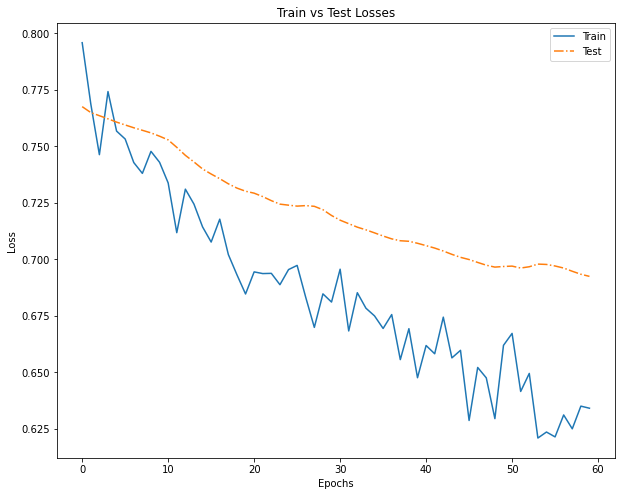

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

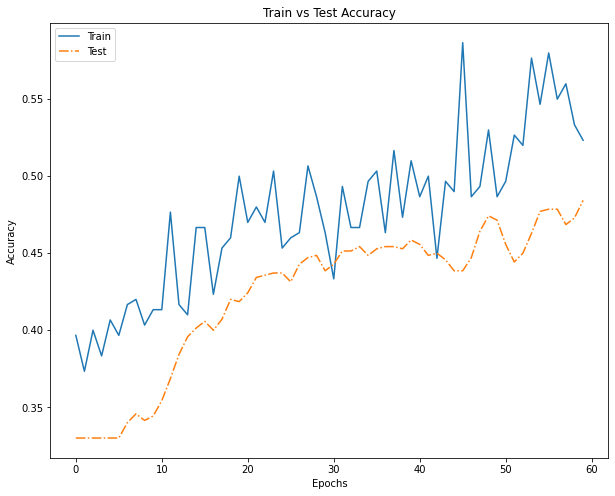

In [ ]:
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

## Loading MONK-3 dataset

In [ ]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

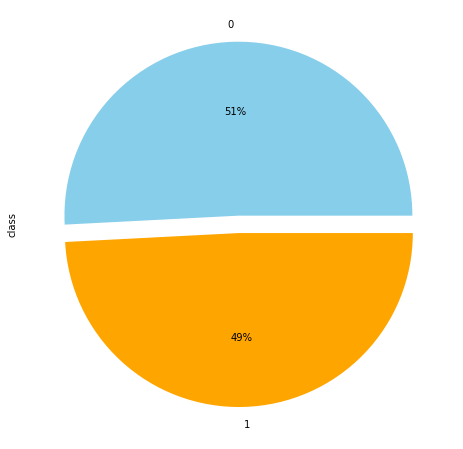

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

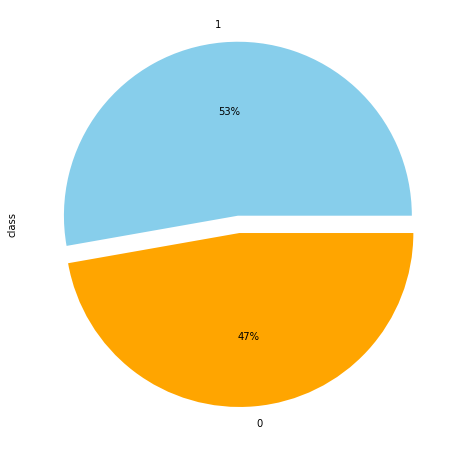

In [ ]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
#prepare train and test data
target_train = df_monk3_train.pop('class')
target_test = df_monk3_test.pop('class')
X_train = df_monk3_train
y_train = target_train
X_test = df_monk3_test
y_test = target_test

In [ ]:
#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
#define the model
model = BinaryClassification(X_train.shape[1], 100)

In [ ]:
#define the loss function 
loss_function = nn.BCELoss()
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.72658 | Acc: 37.000
VALIDATION - Epoch 001: | Loss: 0.69261 | Acc: 51.571
##############################
TRAIN - Epoch 002: | Loss: 0.71986 | Acc: 35.000
VALIDATION - Epoch 002: | Loss: 0.69262 | Acc: 52.286
##############################
TRAIN - Epoch 003: | Loss: 0.73417 | Acc: 39.000
VALIDATION - Epoch 003: | Loss: 0.69306 | Acc: 52.286
##############################
TRAIN - Epoch 004: | Loss: 0.73214 | Acc: 39.500
VALIDATION - Epoch 004: | Loss: 0.69377 | Acc: 50.714
##############################
TRAIN - Epoch 005: | Loss: 0.72971 | Acc: 36.500
VALIDATION - Epoch 005: | Loss: 0.69461 | Acc: 47.571
##############################
TRAIN - Epoch 006: | Loss: 0.72263 | Acc: 41.000
VALIDATION - Epoch 006: | Loss: 0.69551 | Acc: 44.429
##############################
TRAIN - Epoch 007: | Loss: 0.72823 | Acc: 36.000
VALIDATION - Epoch 007: | Loss: 0.69675 | Acc: 43.571
##############################
TRAIN - Epoch 008: | Loss: 0.71628 | Acc: 40.000
VALIDATION - 

In [ ]:
#control the accuracy between true and predict values on test data
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.44      0.59      0.50       204
           1       0.47      0.32      0.38       228

    accuracy                           0.45       432
   macro avg       0.45      0.46      0.44       432
weighted avg       0.45      0.45      0.44       432



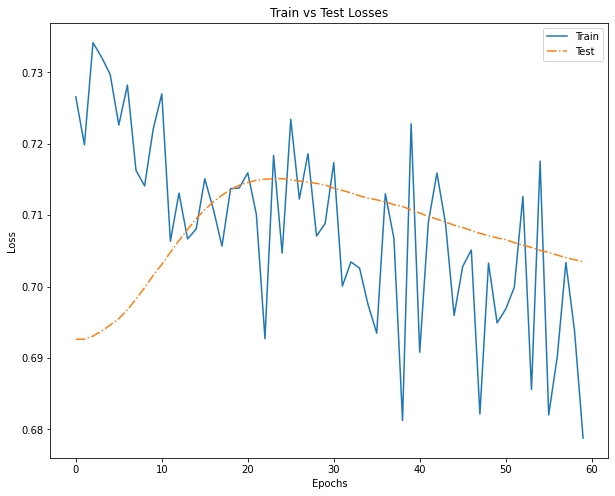

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

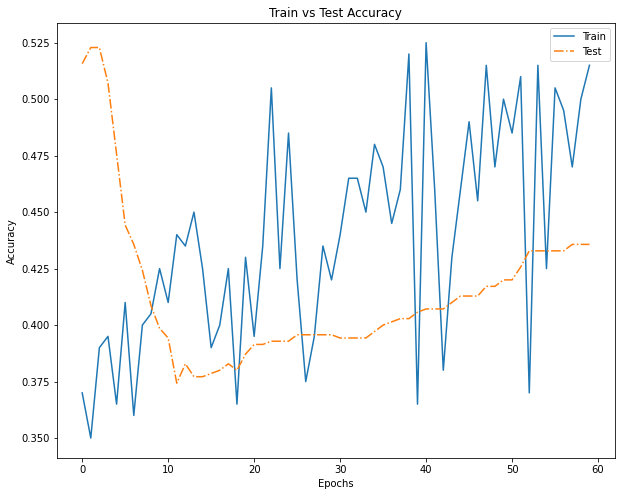

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

## Defining model for regression task

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [ ]:
from sklearn.preprocessing import StandardScaler

class MultiOutputDataset(Dataset):
    def __init__(self, X, y1, y2, scale_data=True):
        #self.X = X
        #self.y1 = y1
        #self.y2 = y2
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X).float()
                y1 = torch.from_numpy(y1).float()
                y2 = torch.from_numpy(y2).float()
                self.y1 = y1.unsqueeze(1)
                self.y2 = y2.unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y1[idx], self.y2[idx]

In [ ]:
#define a neural network
class RegressionNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super(RegressionNet, self).__init__()
        self.layer_in = nn.Linear(n_input, n_hidden1)
        self.layer_1 = nn.Linear(n_hidden1, n_hidden2) 
        self.last_fc = nn.Linear(n_hidden2, 1)
        #self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, inputs):
        x = self.relu(self.layer_in(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        out1 = self.last_fc(x)
        x2 = self.last_fc(x)
        #x = self.layer_out(x)
        #x = self.sigmoid(self.layer_out(x))
        out2 = self.sigmoid(nn.ReLU()(x2))
        
        #return x
        return out1, out2

In [ ]:
#function to define the train phase
def TrainPhase_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss1, loss2, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch1, y_batch2 in data_train:
        X_batch, y_batch1, y_batch2 = X_batch.to(device), y_batch1.to(device), y_batch2.to(device)
        optimizer.zero_grad()
       
        #y_pred = model(X_batch)
        y_pred1, y_pred2 = model(X_batch)
        
        #single_loss = loss(y_pred, y_batch)
        single_loss1 = loss1(y_pred1, y_batch1)
        single_loss2 = loss2(y_pred2, y_batch2)
        single_loss = torch.add(single_loss1, single_loss2)

        #acc = binary_acc(y_pred, y_batch)
        acc = 0
             
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()*X_batch.size(0)
        #epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f} | Acc: {epoch_acc/len(data_train):.3f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses, aggregated_accuracy

In [ ]:
#function to define the evaluate phase
def Evaluate_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f1, loss_f2):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch1, y_batch2 in data_test:
            X_batch, y_batch1, y_batch2 = X_batch.to(device), y_batch1.to(device). y_batch2.to(device)

            #y_test_pred = model(X_batch)
            y_pred1, y_pred2 = model(X_batch)

            #loss = loss_f(y_test_pred, y_batch)
            loss1 = loss_f1(y_pred1, y_batch1)
            loss2 = loss_f2(y_pred2, y_batch2)
            loss = torch.add(loss1, loss2)
            
            #acc = binary_acc(y_test_pred, y_batch)
            acc = 0
                
            #epoch_loss += loss.item()
            epoch_loss += loss.item()*X_batch.size(0)
            #epoch_acc += acc.item()

            #y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            #y_pred_list.append(y_pred_tag.detach().numpy())

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    #ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    aggregated_losses.append(epoch_loss/len(data_test))
    aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')

    #aggregated_losses.append(loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'VALIDATION - Epoch {i+0:03}: | Loss: {loss.item():.5f} | Acc: {acc:.3f}')
    
    return aggregated_losses, aggregated_accuracy
    

## ML-Cup dataset

### Loading the training and blind test dataset

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
#blind_ts = df_blind_ts.values

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']]
X = df_task_tr.drop(labels=['x','y'], axis=1)
X_test = df_blind_ts

print(y.shape)

(1477, 2)


### Internal Test set
We split the training set obtaining an internal test set composed of the 20% of the training set, we will use this internal test set to test the generalization error

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=420)
print(f"X shape: {X_train.shape}")
print(f"X validation shape: {X_validation.shape}")
print(f"y shape: {y_train.shape}")
print(f"y validation shape: {y_validation.shape}")

X shape: (1329, 10)
X validation shape: (148, 10)
y shape: (1329, 2)
y validation shape: (148, 2)


In [ ]:
y1_train = y_train[['x']]
y2_train = y_train[['y']]

y1_validation = y_validation[['x']]
y2_validation = y_validation[['y']]

print(f"First output train shape: {y1_train.shape}")
print(f"Second output train shape: {y2_train.shape}")

print(f"First output validation shape: {y1_validation.shape}")
print(f"Second output validation shape: {y2_validation.shape}")

First output train shape: (1329, 1)
Second output train shape: (1329, 1)
First output validation shape: (148, 1)
Second output validation shape: (148, 1)


In [ ]:
#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
X_validation = X_validation.values

#x_tensor =  torch.from_numpy(X_train).float()
#y1_tensor =  torch.from_numpy(y1_train.values).float()
#y2_tensor =  torch.from_numpy(y2_train.values).float()
#xval_tensor =  torch.from_numpy(X_validation).float()
#yval1_tensor =  torch.from_numpy(y1_validation.values).float()
#yval2_tensor =  torch.from_numpy(y2_validation.values).float()

xtest_tensor =  torch.from_numpy(X_test).float()
#ytest_tensor =  torch.from_numpy(y_test.values).float()

In [ ]:
#prepare dataloader for training
#y1_tensor = y1_tensor.unsqueeze(1)
#y2_tensor = y2_tensor.unsqueeze(1)

print(x_tensor.shape)
#print(yval1_tensor.shape)
#print(yval2_tensor.shape)

#train_ds = TensorDataset(x_tensor, y_tensor)
train_ds = MultiOutputDataset(X_train, y1_train.values, y2_train.values)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([122, 6])


In [ ]:
#prepare dataloader for validation 
#yval1_tensor = yval1_tensor.unsqueeze(1)
#yval2_tensor = yval2_tensor.unsqueeze(1)

#val_ds = TensorDataset(xval_tensor, yval_tensor)
val_ds = MultiOutputDataset(xval_tensor, y1_validation.values, y2_validation.values)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

### Training and evaluate

In [ ]:
#define the model
model = RegressionNet(X_train.shape[1], 100, 50, 2)
model.to(device)
print(model)

RegressionNet(
  (layer_in): Linear(in_features=10, out_features=100, bias=True)
  (layer_1): Linear(in_features=100, out_features=50, bias=True)
  (last_fc): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#define the loss function 
loss_function1 = nn.MSELoss(reduction='mean')
loss_function2 = nn.MSELoss(reduction='mean')
#define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  # Early stopping
  last_loss = 1
  patience = 2
  trigger_times = 0

  model, losses_train, accuracies_train = TrainPhase_Cup(epoch, model, losses_train, accuracies_train, train_loader, loss_function1, loss_function2, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  losses_test, accuracies_test = Evaluate_Cup(epoch, model, losses_test, accuracies_test, val_loader, loss_function1, loss_function2)

  # Early stopping
  if losses_test[epoch - 1] > last_loss:
      trigger_times += 1

      if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break
  else:
      trigger_times = 0
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 31283.78385 | Acc: 0.000


AttributeError: 

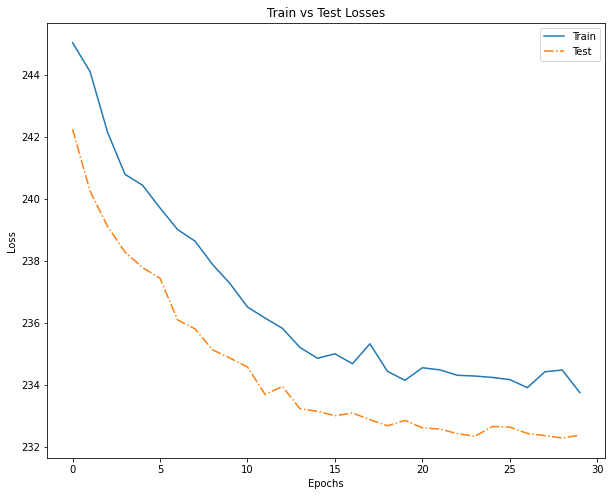

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

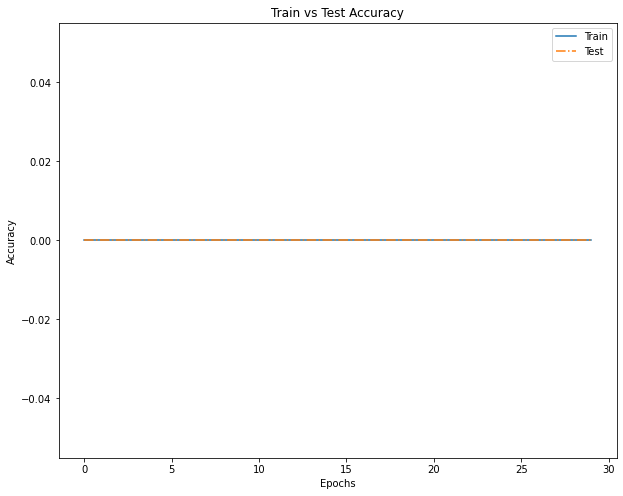

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>